# Disclaimer
※ This is an assignment task from `KAIST ME455 Autonomous Mobile System Programming` class

# Path Planning


In [6]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import math
import heapq

In [8]:
class Env:
    def __init__(self):
        self.x_range = 51 # 이걸로 map 크기 변경 가능
        self.y_range = 31 # 이것도 편집 가능
        self.motions = [(-1, 0), (-1, 1), (0, 1), (1, 1),
                        (1, 0), (1, -1), (0, -1), (-1, -1)] # 8 방향 중 하나만 갈 수 있음
        self.obs = self.obs_map()

    def obs_map(self):
        """
        요기서 값 바꾸면 map을 수정할 수 있음
        """
        x = self.x_range
        y = self.y_range
        obs = set()

        for i in range(x):
            obs.add((i, 0))
            obs.add((i, y - 1))
        for i in range(y):
            obs.add((0, i))
            obs.add((x - 1, i))
        for i in range(10, 21):
            obs.add((i, 15))
        for i in range(15):
            obs.add((20, i))
        for i in range(15, 30):
            obs.add((30, i))
        for i in range(16):
            obs.add((40, i))
        return obs

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

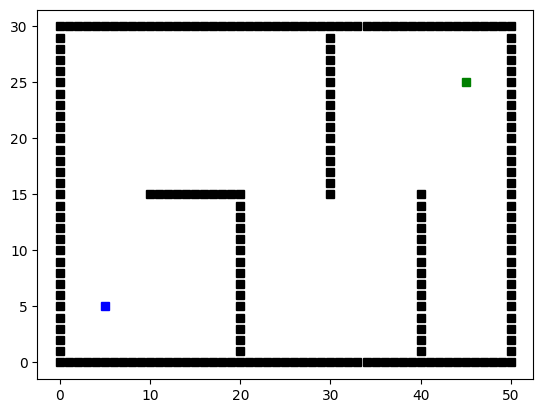

In [5]:
sample_env = Env()
smaple_obs = sample_env.obs_map()

obs_x = [x[0] for x in smaple_obs]
obs_y = [x[1] for x in smaple_obs]

s_start = (5, 5)
s_goal = (45, 25)

plt.plot(s_start[0], s_start[1], "bs", label="Start")
plt.plot(s_goal[0], s_goal[1], "gs", label="Goal")
plt.plot(obs_x, obs_y, "sk", label="Obstacle")

plt.plot

In [9]:
class Plotting:
    def __init__(self, xI, xG, env, name):
        self.xI, self.xG = xI, xG
        self.env = env
        self.obs = self.env.obs_map()
        self.name = name

    def update_obs(self, obs):
        self.obs = obs

    def animation(self, path, visited, name, interval = 20):
        fig, ax = plt.subplots()
        obs_x = [x[0] for x in self.obs]
        obs_y = [x[1] for x in self.obs]

        ax.plot(self.xI[0], self.xI[1], "bs", label="Start")
        ax.plot(self.xG[0], self.xG[1], "gs", label="Goal")
        ax.plot(obs_x, obs_y, "sk", label="Obstacle")
        ax.axis("equal")
        ax.set_title(name)

        # Animation update function
        path_x, path_y = [], []
        visited_x, visited_y = [], []

        def update(frame):
            if frame < len(visited)//interval:
                for i in range(interval):
                    xx = visited[frame*interval+i][0]
                    yy = visited[frame*interval+i][1]
                    visited_x.append(xx)
                    visited_y.append(yy)
                ax.plot(visited_x, visited_y, "o", color="gray", markersize=3)
            elif frame < len(visited)//interval + 1:
                rest = len(visited) - (frame)*interval
                for i in range(rest):
                    xx = visited[frame*interval+i][0]
                    yy = visited[frame*interval+i][1]
                    visited_x.append(xx)
                    visited_y.append(yy)
                visited_x.append(xx)
                visited_y.append(yy)
                ax.plot(visited_x, visited_y, "o", color="gray", markersize=3)

            if frame > len(visited)//interval:
                path_x.append(path[frame-len(visited)//interval-1][0])
                path_y.append(path[frame-len(visited)//interval-1][1])
                ax.plot(path_x, path_y, "-r", linewidth=2)


        fig.legend()
        ani = FuncAnimation(fig, update, frames=(len(visited)//interval+1)+len(path), repeat=False, interval=5)
        save_name = self.name + ".gif"
        ani.save(os.path.join(root, save_name), fps=100)
        plt.close()

### Fill in the blanks to complete the algorithms

heapq.heappush(heap, item): Adds the element item to the heap while maintaining the heap property. This function ensures that the smallest element can always be accessed at the root.


ex) heapq.heappush(List, (cost, position))


heapq.heappop(heap): Removes and returns the smallest element from the heap. If the heap is empty, it raises an IndexError.

In [10]:
class Dijkstra:
    def __init__(self, s_start, s_goal, heuristic_type, env):
        self.s_start = s_start
        self.s_goal = s_goal
        self.heuristic_type = heuristic_type

        self.Env = env

        self.u_set = self.Env.motions
        self.obs = self.Env.obs

        # open
        self.OPEN = []

        # closed
        self.CLOSED = []

        # predecessors
        self.g = dict()
        self.PARENT = dict()

    def searching(self):
        """
        Breadth-first Searching.
        :return: path, visited order
        """
        self.PARENT[self.s_start] = self.s_start
        self.g[self.s_start] = 0
        self.g[self.s_goal] = math.inf

        # initial push
        heapq.heappush(self.OPEN, (self.g[self.s_start], self.s_start))

        while self.OPEN:
            # initial pop
            _, s = heapq.heappop(self.OPEN)

            self.CLOSED.append(s)

            # terminal condition
            if s == self.s_goal:
                break

            for v in self.get_neighbor(s):
                new_cost = self.g[s] + self.cost(s, v)

                if v not in self.g:
                    self.g[v] = math.inf

                if new_cost < self.g[v]:
                    self.g[v] = new_cost
                    self.PARENT[v] = s

                    heapq.heappush(self.OPEN, (self.g[v], v))

        return self.extract_path(self.PARENT), self.CLOSED

    def get_neighbor(self, s):
        """
        find neighbors of state s that not in obstacles.
        :param s: state
        :return: neighbors
        """
        return [(s[0] + u[0], s[1] + u[1]) for u in self.u_set]

    def cost(self, s_start, s_goal):
        """
        Calculate Cost for this motion
        :param s_start: starting node
        :param s_goal: end node
        :return:  Cost for this motion
        :note: Cost function could be more complicate!

        utilize "math.hypot" function to calculate the distance(cost)
        """
        if self.is_collision(s_start, s_goal):
            return math.inf

        return math.hypot(s_start[0] - s_goal[0], s_start[1] - s_goal[1])

    def is_collision(self, s_start, s_end):
        """
        check if the line segment (s_start, s_end) is collision.
        :param s_start: start node
        :param s_end: end node
        :return: True: is collision / False: not collision
        """
        if s_start in self.obs or s_end in self.obs:
            return True

        if s_start[0] != s_end[0] and s_start[1] != s_end[1]:
            if s_end[0] - s_start[0] == s_start[1] - s_end[1]:
                s1 = (min(s_start[0], s_end[0]), min(s_start[1], s_end[1]))
                s2 = (max(s_start[0], s_end[0]), max(s_start[1], s_end[1]))
            else:
                s1 = (min(s_start[0], s_end[0]), max(s_start[1], s_end[1]))
                s2 = (max(s_start[0], s_end[0]), min(s_start[1], s_end[1]))

            if s1 in self.obs or s2 in self.obs:
                return True

        return False

    def extract_path(self, PARENT):
        """
        Extract the path based on the PARENT set.
        :return: The planning path
        """
        path = [self.s_goal]
        s = self.s_goal

        while True:
            s = PARENT[s]
            path.append(s)

            if s == self.s_start:
                break

        return list(path)


In [12]:
class AStar:
    """AStar set the cost + heuristics as the priority
    """
    def __init__(self, s_start, s_goal, heuristic_type, env):
        self.s_start = s_start
        self.s_goal = s_goal
        self.heuristic_type = heuristic_type

        self.Env = env

        self.u_set = self.Env.motions
        self.obs = self.Env.obs

        # open
        self.OPEN = []

        # closed
        self.CLOSED = []

        # predecessors
        self.g = dict()
        self.PARENT = dict()

    def searching(self):
        """
        A_star Searching.
        :return: path, visited order
        utilize "f_value" function below to consider heuristics
        """

        self.PARENT[self.s_start] = self.s_start
        self.g[self.s_start] = 0
        self.g[self.s_goal] = math.inf
        heapq.heappush(self.OPEN, (self.f_value(self.s_start), self.s_start))

        while self.OPEN:
            _, s = heapq.heappop(self.OPEN)
            self.CLOSED.append(s)

            if s == self.s_goal:
                break

            for v in self.get_neighbor(s):
                new_cost = self.g[s] + self.cost(s, v)

                if v not in self.g:
                    self.g[v] = math.inf

                if new_cost < self.g[v]:
                    self.g[v] = new_cost
                    self.PARENT[v] = s

                    heapq.heappush(self.OPEN, (self.f_value(v), v))

        return self.extract_path(self.PARENT), self.CLOSED

    def get_neighbor(self, s):
        """
        find neighbors of state s that not in obstacles.
        :param s: state
        :return: neighbors
        """

        return [(s[0] + u[0], s[1] + u[1]) for u in self.u_set]

    def cost(self, s_start, s_goal):
        """
        Calculate Cost for this motion
        :param s_start: starting node
        :param s_goal: end node
        :return:  Cost for this motion
        :note: Cost function could be more complicate!
        utilize "math.hypot" function to calculate the distance(cost)
        """

        if self.is_collision(s_start, s_goal):
            return math.inf

        return math.hypot(s_start[0] - s_goal[0], s_start[1] - s_goal[1])

    def is_collision(self, s_start, s_end):
        """
        check if the line segment (s_start, s_end) is collision.
        :param s_start: start node
        :param s_end: end node
        :return: True: is collision / False: not collision
        """

        if s_start in self.obs or s_end in self.obs:
            return True

        if s_start[0] != s_end[0] and s_start[1] != s_end[1]:
            if s_end[0] - s_start[0] == s_start[1] - s_end[1]:
                s1 = (min(s_start[0], s_end[0]), min(s_start[1], s_end[1]))
                s2 = (max(s_start[0], s_end[0]), max(s_start[1], s_end[1]))
            else:
                s1 = (min(s_start[0], s_end[0]), max(s_start[1], s_end[1]))
                s2 = (max(s_start[0], s_end[0]), min(s_start[1], s_end[1]))

            if s1 in self.obs or s2 in self.obs:
                return True

        return False

    def f_value(self, s):
        """
        f = g + h. (g: Cost to come, h: heuristic value)
        :param s: current state
        :return: f
        """

        return self.g[s] + self.heuristic(s)

    def extract_path(self, PARENT):
        """
        Extract the path based on the PARENT set.
        :return: The planning path
        """

        path = [self.s_goal]
        s = self.s_goal

        while True:
            s = PARENT[s]
            path.append(s)

            if s == self.s_start:
                break

        return list(path)

    def heuristic(self, s):
        """
        Calculate heuristic.
        :param s: current node (state)
        :return: heuristic function value
        utilize "math.hypot" function to calculate the distance(cost) from target position(goal)
        """
        goal = self.s_goal

        return math.hypot(s[0] - goal[0], s[1] - goal[1])

In [13]:
s_start = (5, 5)
s_goal = (45, 25)

env = Env()

astar = AStar(s_start, s_goal, "euclidean", env)
plot = Plotting(s_start, s_goal, env, name="A_star")

path, visited = astar.searching()

plot.animation(path, visited, "A* Animation")

In [11]:
s_start = (5, 5)
s_goal = (45, 25)

env = Env()

astar = Dijkstra(s_start, s_goal, "None", env)
plot = Plotting(s_start, s_goal, env, name="Dijkstra")

path, visited = astar.searching()

plot.animation(path, visited, "Dijkstra* Animation")

### Custom map

In [ ]:
class OwnEnv:
    def __init__(self):
        self.x_range = 101
        self.y_range = 51
        self.motions = [(-1, 0), (-1, 1), (0, 1), (1, 1),
                        (1, 0), (1, -1), (0, -1), (-1, -1)]
        self.obs = self.obs_map()

    def obs_map(self):
        x = self.x_range
        y = self.y_range
        obs = set()

        ######## Make the wall ########


        for i in range(x):  # Top and bottom walls
            obs.add((i, 0))
            obs.add((i, y - 1))
        for i in range(y):  # Left and right walls
            obs.add((0, i))
            obs.add((x - 1, i))



        for i in range(20, 81): 
            obs.add((i, 25))

        for j in range(10, 41):  
            if j != 30: 
                obs.add((50, j))

        # Diagonal barriers
        for i in range(10, 30):  
            obs.add((i, i)) # 10~29

        for i in range(70, 90):  
            obs.add((i, 99 - i))
        ################################
        return obs

In [ ]:
import time
import math
import heapq

s_start = (5, 5)
s_goal = (95, 45)

env = OwnEnv()


print("Running A* Algorithm...")

execution_time_astar = 0.0

for i in range(100):
    start_time_astar = time.time()
    astar = AStar(s_start, s_goal, "euclidean", env)
    path, visited = astar.searching()
    execution_time = time.time() - start_time_astar
    execution_time_astar += execution_time

execution_time_astar /= 100


print(f"A* Execution Time: {execution_time_astar:.4f} seconds")
print(f"A* Nodes Visited: {len(visited)}")
print(f"A* Path Length: {len(path)}")

plot = Plotting(s_start, s_goal, env, name="Own_A_star")
plot.animation(path, visited, "A* Animation")

Running A* Algorithm...
A* Execution Time: 0.0819 seconds
A* Nodes Visited: 4025
A* Path Length: 98


In [32]:
s_start = (5, 5)
s_goal = (95, 45)

env = OwnEnv()

# Compare Dijkstra's Algorithm
print("\nRunning Dijkstra's Algorithm...")

execution_time_dijkstra = 0.0

for i in range(100):
    start_time_dijkstra = time.time()
    astar = Dijkstra(s_start, s_goal, "None", env)
    path, visited = astar.searching()
    execution_time = time.time() - start_time_dijkstra
    execution_time_dijkstra += execution_time

execution_time_dijkstra /= 100


print(f"Dijkstra Execution Time: {execution_time_dijkstra:.4f} seconds")
print(f"Dijkstra Nodes Visited: {len(visited)}")
print(f"Dijkstra Path Length: {len(path)}")

plot = Plotting(s_start, s_goal, env, name="Own_Dijkstra")
plot.animation(path, visited, "Dijkstra* Animation")


Running Dijkstra's Algorithm...
Dijkstra Execution Time: 0.0911 seconds
Dijkstra Nodes Visited: 4871
Dijkstra Path Length: 98
